In [1]:
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
import time
from math import ceil
import yaml, laspy
import lithops
import pandas as pd
import numpy as np
# import neilpy
from lithops.storage.cloud_proxy import open, os as os_cl
from lithops import ServerlessExecutor
from lidarpartitioner import lidarutils, utils
from lidarpartitioner.las_partitioner import Partitioner
from lidarpartitioner.lidarutils import *
import lidarpartitioner
from lithops.worker.utils import get_memory_usage
from sklearn.neighbors import KDTree

In [3]:
# datetime object containing current date and time
now = datetime.now()

# dd/mm/YY H:M:S
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")

datet = dt_string.replace(":", "_").replace(" ","_").replace("/","_")

In [4]:
def partition_file(fname, out_dir, num_points, sufix, buffer):
    divider = Partitioner(fname, sufix)
    m_threshold = num_points
    divider.make_partition(out_dir, capacity=m_threshold, buffer=buffer)

In [5]:
def outlier_filter(id, file, remove_out, buffer, call_time):
    
    st_map_process = time.time()
    Allprocessing_time = dict()
    Allprocessing_time['Object_name'] = file.split('/')[-1]
    Allprocessing_time['Map_ID'] = id
    Allprocessing_time['Buffer'] = buffer
    Allprocessing_time['Time_Mapstart'] = round(st_map_process - call_time, 3)
    print("ID of the function: %s" % str(id))
    
    
    # read data stream
    st_read = time.time()
    with open(file, 'rb') as f:
        inF = laspy.read(f)
    point_cloud = np.vstack((inF.x, inF.y, inF.z, inF.withheld)).T
    download_data = time.time() - st_read
    Allprocessing_time['Downloading_Time'] = round(download_data, 3) 
    
    
    # Start applying outliers filter (radius method)
    # https://pdal.io/PDAL.pdf
    st_filter = time.time()
    radius = 2
    min_k = 4
    print(len(point_cloud))
    try:
        tree = KDTree(point_cloud[:,:3], leaf_size=40)
        b = point_cloud[:,3] == 0
        print(set(b), len(b))
        p_ind = np.where(b)
        k = tree.query_radius(point_cloud[b][:,:3], r=radius, count_only=True)
        outlier = np.asarray(list(map(lambda x: x < min_k, k)))
        not_outlier = list(~np.array(outlier))
        indices = np.asarray(p_ind[0])[not_outlier]
        filtering_time = time.time() - st_filter
        
        st_wres = time.time()
        fname, data = lidarutils.writer_lasfile(inF, indices, file, out_dir=remove_out,
                                                 reduce_stream = True, is_bool = False)
        en_wres = time.time() - st_wres
    except Exception as e:
        print('Failed!!. Reason: %s' %(e))
    
    Allprocessing_time['Filtering_time'] = round(filtering_time, 3)
    Allprocessing_time['Save_points'] = round(en_wres, 3)
    Allprocessing_time['Maping_time'] = round(time.time() - st_map_process, 3)
    Allprocessing_time['sendResult_time'] = time.time()
    
    return Allprocessing_time, data


def merg_res(results):

    st_reducer = time.time()
    pr_time = dict()
    merging = dict()
    Filtering_time, RWData_time, Maping_time, sendResult_time  = [], [], [], []
    Save_points, PeriodTime_Mapstart = [], []
    num_part = len(results)
    buffer = results[0][0]['Buffer']
    print(num_part)
    
    res_mapdata = []
    for res in results:
        obj = dict()
        RWData_time.append(res[0]['Downloading_Time'])
        Filtering_time.append(res[0]['Filtering_time'])
        Save_points.append(res[0]['Save_points'])
        Maping_time.append(res[0]['Maping_time'])
        PeriodTime_Mapstart.append(res[0]['Time_Mapstart'])
        sendResult_time.append(st_reducer - res[0]['sendResult_time'])
        obj['Object_name'] = res[0]['Object_name']
        obj['data_stream'] = res[1]
        res_mapdata.append(obj)
    del results
    
    # Start merging all the results
    st_merg = time.time()
    m_res = merg_files(res_mapdata, num_part, buffer)
    
    merging_time = time.time() - st_merg
    merging['Merging_time'] = merging_time
    
    pr_time['Funcs_numbers'] = num_part
    pr_time['File_name'] = m_res['File_name']
    pr_time['Points_number'] = m_res['Points_number']
    pr_time['Time_Mapstart'] = min(PeriodTime_Mapstart)
    pr_time['Time_Redstart'] = round(min(sendResult_time), 3)
    pr_time['Downloading_Time'] = max(RWData_time)
    pr_time['Filtering_time'] = max(Filtering_time)
    pr_time['Save_points'] = max(Save_points)
    pr_time['Maping_time'] = max(Maping_time)
    pr_time['Saving_data_time'] = m_res['Saving_data_time']
    pr_time['Merging_files_time'] = m_res['Merging_files_time']
    pr_time['Merged_uploading_time'] = m_res['Merged_uploading_time']
    pr_time['Merging_process'] = m_res['Merging_process']
    pr_time['Reduction_time'] = round(time.time() - st_reducer, 3)
    
    return pr_time

In [6]:
%%time
processing_time = []
data_folder = 'data'
chip_folder = 'chipres'
res_map_folder = 'removed_outliers'
res_red_folder = 'merged_files'
fname = data_folder + '/' + "Coloreado (RGB) 2016 - PNOA-2016-CAT-352-4556-ORT-CLA-COL.las"
#"Coloreado (RGB) 2016 - PNOA-2016-CAT-352-4556-ORT-CLA-COL.las" "lasfile.las"
# "Coloreado (RGB) 2016 - PNOA-2016-CAT-352-4554-ORT-CLA-COL.las"
# "Coloreado (RGB) 2016 - PNOA-2016-CAT-338-4556-ORT-CLA-COL.las"
folders = [chip_folder, res_map_folder]

for i in range(9):
    
    
    if i > 0:
        
        # Start partitioning
        # Clean folder in bucket if exists, if not create it
        [lidarutils.clean_folder(folder) for folder in folders]
    
        # Set variables and start partitioning
        partitions = 2**i
        buffer = 10
        num_points = ceil(5492898/partitions) #5492898 3791954 1373224 343306
        # print(num_points)
        
        partition_args = [(fname, chip_folder, num_points, i, buffer) for i in range(1)]
        st_split = time.time()
        with ServerlessExecutor(runtime_memory=3072) as exec: #runtime_memory=3072
            exec.map(partition_file, partition_args)
            exec.get_result()
        end_split = time.time() - st_split
        print(f'Total partition time: {end_split} s')
    
    # Processing files resulting from the partition stage 
    st_processing = time.time()
    if i == 0:
        map_runtime_memory = 2048
    elif i > 4:
        map_runtime_memory = 512
    else:
        map_runtime_memory = 1024
        
    files = os_cl.listdir(chip_folder)
    process_args = [(chip_folder + '/' + file, res_map_folder, buffer, st_processing) for file in files] if i > 0 \
                    else [(fname, res_map_folder, 0, st_processing)]
    with ServerlessExecutor(runtime="ammarokran/new-smrf-conda36:1.0.6") as exec:
        exec.map_reduce(outlier_filter, process_args, merg_res, map_runtime_memory=map_runtime_memory,
                        reduce_runtime_memory=4096, include_modules=['lidarutils', 'lidarpartitioner', 'utils'])
        st_get = time.time()
        res = exec.get_result()
        end_get = time.time() - st_get
        # fexec.clean()
    end_processing = time.time() - st_processing
    res['GettingResult_time'] = round(end_get, 3)
    res['Processing_time'] = round(end_processing, 3)
    processing_time.append(res)
    print(f'Total processing time: {end_processing} s')

2021-11-03 17:11:31,987 [INFO] lithops.config -- Lithops v2.3.1
2021-11-03 17:11:32,035 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS Storage client created - Region: us-east
2021-11-03 17:11:32,035 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: us-east - Namespace: fadi.hassan@urv.cat_fadi
2021-11-03 17:11:32,035 [INFO] lithops.executors -- Serverless Executor created with ID: 3ddaa2-0
2021-11-03 17:11:32,039 [INFO] lithops.invokers -- ExecutorID 3ddaa2-0 | JobID M000 - Selected Runtime: ammarokran/new-smrf-conda36:1.0.6 - 2048MB 
2021-11-03 17:11:32,075 [INFO] lithops.job.job -- ExecutorID 3ddaa2-0 | JobID M000 - Uploading function and data - Total: 49.9KiB
2021-11-03 17:11:33,523 [INFO] lithops.invokers -- ExecutorID 3ddaa2-0 | JobID M000 - Starting function invocation: outlier_filter() - Total: 1 activations
2021-11-03 17:11:33,630 [INFO] lithops.invokers -- ExecutorID 3ddaa2-0 | JobID M000 - View execution logs at C:\Users\Ammar\Ap

    0%|          | 0/2  

2021-11-03 17:14:00,805 [INFO] lithops.executors -- ExecutorID 3ddaa2-0 - Cleaning temporary data


Total processing time: 149.52755498886108 s


2021-11-03 17:16:57,256 [INFO] lithops.config -- Lithops v2.3.1
2021-11-03 17:16:57,288 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS Storage client created - Region: us-east
2021-11-03 17:16:57,292 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: us-east - Namespace: fadi.hassan@urv.cat_fadi
2021-11-03 17:16:57,292 [INFO] lithops.executors -- Serverless Executor created with ID: 3ddaa2-1
2021-11-03 17:16:57,292 [INFO] lithops.invokers -- ExecutorID 3ddaa2-1 | JobID M000 - Selected Runtime: ammarokran/part-lidar:1.0 - 3072MB 
2021-11-03 17:16:57,320 [INFO] lithops.job.job -- ExecutorID 3ddaa2-1 | JobID M000 - Uploading function and data - Total: 48.0KiB
2021-11-03 17:16:58,713 [INFO] lithops.invokers -- ExecutorID 3ddaa2-1 | JobID M000 - Starting function invocation: partition_file() - Total: 1 activations
2021-11-03 17:16:58,834 [INFO] lithops.invokers -- ExecutorID 3ddaa2-1 | JobID M000 - View execution logs at C:\Users\Ammar\AppData\Lo

    0%|          | 0/1  

2021-11-03 17:19:36,110 [INFO] lithops.executors -- ExecutorID 3ddaa2-1 - Cleaning temporary data
2021-11-03 17:19:36,265 [INFO] lithops.config -- Lithops v2.3.1


Total partition time: 158.86642861366272 s


2021-11-03 17:19:36,469 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS Storage client created - Region: us-east
2021-11-03 17:19:36,473 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: us-east - Namespace: fadi.hassan@urv.cat_fadi
2021-11-03 17:19:36,477 [INFO] lithops.executors -- Serverless Executor created with ID: 3ddaa2-2
2021-11-03 17:19:36,477 [INFO] lithops.invokers -- ExecutorID 3ddaa2-2 | JobID M000 - Selected Runtime: ammarokran/new-smrf-conda36:1.0.6 - 1024MB 
2021-11-03 17:19:36,639 [INFO] lithops.job.job -- ExecutorID 3ddaa2-2 | JobID M000 - Uploading function and data - Total: 50.1KiB
2021-11-03 17:19:37,934 [INFO] lithops.invokers -- ExecutorID 3ddaa2-2 | JobID M000 - Starting function invocation: outlier_filter() - Total: 2 activations
2021-11-03 17:19:38,040 [INFO] lithops.invokers -- ExecutorID 3ddaa2-2 | JobID M000 - View execution logs at C:\Users\Ammar\AppData\Local\Temp\lithops\logs\3ddaa2-2-M000.log
2021-11-03 17:19

    0%|          | 0/3  

2021-11-03 17:21:13,587 [INFO] lithops.executors -- ExecutorID 3ddaa2-2 - Cleaning temporary data


Total processing time: 97.47281408309937 s


2021-11-03 17:21:15,342 [INFO] lithops.config -- Lithops v2.3.1
2021-11-03 17:21:15,376 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS Storage client created - Region: us-east
2021-11-03 17:21:15,376 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: us-east - Namespace: fadi.hassan@urv.cat_fadi
2021-11-03 17:21:15,380 [INFO] lithops.executors -- Serverless Executor created with ID: 3ddaa2-3
2021-11-03 17:21:15,380 [INFO] lithops.invokers -- ExecutorID 3ddaa2-3 | JobID M000 - Selected Runtime: ammarokran/part-lidar:1.0 - 3072MB 
2021-11-03 17:21:15,420 [INFO] lithops.job.job -- ExecutorID 3ddaa2-3 | JobID M000 - Uploading function and data - Total: 48.0KiB
2021-11-03 17:21:16,466 [INFO] lithops.invokers -- ExecutorID 3ddaa2-3 | JobID M000 - Starting function invocation: partition_file() - Total: 1 activations
2021-11-03 17:21:16,582 [INFO] lithops.invokers -- ExecutorID 3ddaa2-3 | JobID M000 - View execution logs at C:\Users\Ammar\AppData\Lo

    0%|          | 0/1  

2021-11-03 17:23:35,906 [INFO] lithops.executors -- ExecutorID 3ddaa2-3 - Cleaning temporary data
2021-11-03 17:23:36,062 [INFO] lithops.config -- Lithops v2.3.1
2021-11-03 17:23:36,082 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS Storage client created - Region: us-east
2021-11-03 17:23:36,082 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: us-east - Namespace: fadi.hassan@urv.cat_fadi
2021-11-03 17:23:36,086 [INFO] lithops.executors -- Serverless Executor created with ID: 3ddaa2-4
2021-11-03 17:23:36,086 [INFO] lithops.invokers -- ExecutorID 3ddaa2-4 | JobID M000 - Selected Runtime: ammarokran/new-smrf-conda36:1.0.6 - 1024MB 


Total partition time: 140.57521748542786 s


2021-11-03 17:23:36,122 [INFO] lithops.job.job -- ExecutorID 3ddaa2-4 | JobID M000 - Uploading function and data - Total: 50.4KiB
2021-11-03 17:23:37,510 [INFO] lithops.invokers -- ExecutorID 3ddaa2-4 | JobID M000 - Starting function invocation: outlier_filter() - Total: 4 activations
2021-11-03 17:23:37,630 [INFO] lithops.invokers -- ExecutorID 3ddaa2-4 | JobID M000 - View execution logs at C:\Users\Ammar\AppData\Local\Temp\lithops\logs\3ddaa2-4-M000.log
2021-11-03 17:23:37,634 [INFO] lithops.invokers -- ExecutorID 3ddaa2-4 | JobID R000 - Selected Runtime: ammarokran/new-smrf-conda36:1.0.6 - 4096MB 
2021-11-03 17:23:37,674 [INFO] lithops.job.job -- ExecutorID 3ddaa2-4 | JobID R000 - Uploading function and data - Total: 50.6KiB
2021-11-03 17:23:38,232 [INFO] lithops.invokers -- ExecutorID 3ddaa2-4 | JobID R000 - Starting function invocation: merg_res() - Total: 1 activations
2021-11-03 17:23:38,345 [INFO] lithops.invokers -- ExecutorID 3ddaa2-4 | JobID R000 - View execution logs at C:\

    0%|          | 0/5  

2021-11-03 17:24:39,720 [INFO] lithops.executors -- ExecutorID 3ddaa2-4 - Cleaning temporary data


Total processing time: 63.82280254364014 s


2021-11-03 17:24:43,229 [INFO] lithops.config -- Lithops v2.3.1
2021-11-03 17:24:43,247 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS Storage client created - Region: us-east
2021-11-03 17:24:43,251 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: us-east - Namespace: fadi.hassan@urv.cat_fadi
2021-11-03 17:24:43,251 [INFO] lithops.executors -- Serverless Executor created with ID: 3ddaa2-5
2021-11-03 17:24:43,251 [INFO] lithops.invokers -- ExecutorID 3ddaa2-5 | JobID M000 - Selected Runtime: ammarokran/part-lidar:1.0 - 3072MB 
2021-11-03 17:24:43,275 [INFO] lithops.job.job -- ExecutorID 3ddaa2-5 | JobID M000 - Uploading function and data - Total: 48.0KiB
2021-11-03 17:24:44,528 [INFO] lithops.invokers -- ExecutorID 3ddaa2-5 | JobID M000 - Starting function invocation: partition_file() - Total: 1 activations
2021-11-03 17:24:44,632 [INFO] lithops.invokers -- ExecutorID 3ddaa2-5 | JobID M000 - View execution logs at C:\Users\Ammar\AppData\Lo

    0%|          | 0/1  

2021-11-03 17:27:10,671 [INFO] lithops.executors -- ExecutorID 3ddaa2-5 - Cleaning temporary data
2021-11-03 17:27:10,821 [INFO] lithops.config -- Lithops v2.3.1


Total partition time: 147.45208525657654 s


2021-11-03 17:27:10,980 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS Storage client created - Region: us-east
2021-11-03 17:27:10,991 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: us-east - Namespace: fadi.hassan@urv.cat_fadi
2021-11-03 17:27:10,991 [INFO] lithops.executors -- Serverless Executor created with ID: 3ddaa2-6
2021-11-03 17:27:10,991 [INFO] lithops.invokers -- ExecutorID 3ddaa2-6 | JobID M000 - Selected Runtime: ammarokran/new-smrf-conda36:1.0.6 - 1024MB 
2021-11-03 17:27:11,041 [INFO] lithops.job.job -- ExecutorID 3ddaa2-6 | JobID M000 - Uploading function and data - Total: 51.1KiB
2021-11-03 17:27:12,330 [INFO] lithops.invokers -- ExecutorID 3ddaa2-6 | JobID M000 - Starting function invocation: outlier_filter() - Total: 8 activations
2021-11-03 17:27:12,441 [INFO] lithops.invokers -- ExecutorID 3ddaa2-6 | JobID M000 - View execution logs at C:\Users\Ammar\AppData\Local\Temp\lithops\logs\3ddaa2-6-M000.log
2021-11-03 17:27

    0%|          | 0/9  

2021-11-03 17:27:51,662 [INFO] lithops.executors -- ExecutorID 3ddaa2-6 - Cleaning temporary data


Total processing time: 40.994194984436035 s


2021-11-03 17:27:58,012 [INFO] lithops.config -- Lithops v2.3.1
2021-11-03 17:27:58,056 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS Storage client created - Region: us-east
2021-11-03 17:27:58,060 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: us-east - Namespace: fadi.hassan@urv.cat_fadi
2021-11-03 17:27:58,060 [INFO] lithops.executors -- Serverless Executor created with ID: 3ddaa2-7
2021-11-03 17:27:58,060 [INFO] lithops.invokers -- ExecutorID 3ddaa2-7 | JobID M000 - Selected Runtime: ammarokran/part-lidar:1.0 - 3072MB 
2021-11-03 17:27:58,096 [INFO] lithops.job.job -- ExecutorID 3ddaa2-7 | JobID M000 - Uploading function and data - Total: 48.0KiB
2021-11-03 17:27:59,269 [INFO] lithops.invokers -- ExecutorID 3ddaa2-7 | JobID M000 - Starting function invocation: partition_file() - Total: 1 activations
2021-11-03 17:27:59,377 [INFO] lithops.invokers -- ExecutorID 3ddaa2-7 | JobID M000 - View execution logs at C:\Users\Ammar\AppData\Lo

    0%|          | 0/1  

2021-11-03 17:30:19,899 [INFO] lithops.executors -- ExecutorID 3ddaa2-7 - Cleaning temporary data
2021-11-03 17:30:20,076 [INFO] lithops.config -- Lithops v2.3.1
2021-11-03 17:30:20,099 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS Storage client created - Region: us-east


Total partition time: 141.89501237869263 s


2021-11-03 17:30:20,099 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: us-east - Namespace: fadi.hassan@urv.cat_fadi
2021-11-03 17:30:20,103 [INFO] lithops.executors -- Serverless Executor created with ID: 3ddaa2-8
2021-11-03 17:30:20,103 [INFO] lithops.invokers -- ExecutorID 3ddaa2-8 | JobID M000 - Selected Runtime: ammarokran/new-smrf-conda36:1.0.6 - 1024MB 
2021-11-03 17:30:20,147 [INFO] lithops.job.job -- ExecutorID 3ddaa2-8 | JobID M000 - Uploading function and data - Total: 52.4KiB
2021-11-03 17:30:21,400 [INFO] lithops.invokers -- ExecutorID 3ddaa2-8 | JobID M000 - Starting function invocation: outlier_filter() - Total: 16 activations
2021-11-03 17:30:21,525 [INFO] lithops.invokers -- ExecutorID 3ddaa2-8 | JobID M000 - View execution logs at C:\Users\Ammar\AppData\Local\Temp\lithops\logs\3ddaa2-8-M000.log
2021-11-03 17:30:21,525 [INFO] lithops.invokers -- ExecutorID 3ddaa2-8 | JobID R000 - Selected Runtime: ammarokran/new-smrf-conda36:1.0.6 -

    0%|          | 0/17  

2021-11-03 17:31:13,225 [INFO] lithops.executors -- ExecutorID 3ddaa2-8 - Cleaning temporary data


Total processing time: 53.325756549835205 s


2021-11-03 17:31:24,097 [INFO] lithops.config -- Lithops v2.3.1
2021-11-03 17:31:24,129 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS Storage client created - Region: us-east
2021-11-03 17:31:24,129 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: us-east - Namespace: fadi.hassan@urv.cat_fadi
2021-11-03 17:31:24,133 [INFO] lithops.executors -- Serverless Executor created with ID: 3ddaa2-9
2021-11-03 17:31:24,133 [INFO] lithops.invokers -- ExecutorID 3ddaa2-9 | JobID M000 - Selected Runtime: ammarokran/part-lidar:1.0 - 3072MB 
2021-11-03 17:31:24,167 [INFO] lithops.job.job -- ExecutorID 3ddaa2-9 | JobID M000 - Uploading function and data - Total: 48.0KiB
2021-11-03 17:31:25,398 [INFO] lithops.invokers -- ExecutorID 3ddaa2-9 | JobID M000 - Starting function invocation: partition_file() - Total: 1 activations
2021-11-03 17:31:25,509 [INFO] lithops.invokers -- ExecutorID 3ddaa2-9 | JobID M000 - View execution logs at C:\Users\Ammar\AppData\Lo

    0%|          | 0/1  

2021-11-03 17:33:50,890 [INFO] lithops.executors -- ExecutorID 3ddaa2-9 - Cleaning temporary data


Total partition time: 146.81345105171204 s


2021-11-03 17:33:51,058 [INFO] lithops.config -- Lithops v2.3.1
2021-11-03 17:33:51,192 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS Storage client created - Region: us-east
2021-11-03 17:33:51,192 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: us-east - Namespace: fadi.hassan@urv.cat_fadi
2021-11-03 17:33:51,196 [INFO] lithops.executors -- Serverless Executor created with ID: 3ddaa2-10
2021-11-03 17:33:51,196 [INFO] lithops.invokers -- ExecutorID 3ddaa2-10 | JobID M000 - Selected Runtime: ammarokran/new-smrf-conda36:1.0.6 - 512MB 
2021-11-03 17:33:51,519 [INFO] lithops.job.job -- ExecutorID 3ddaa2-10 | JobID M000 - Uploading function and data - Total: 55.0KiB
2021-11-03 17:33:52,755 [INFO] lithops.invokers -- ExecutorID 3ddaa2-10 | JobID M000 - Starting function invocation: outlier_filter() - Total: 32 activations
2021-11-03 17:33:53,064 [INFO] lithops.invokers -- ExecutorID 3ddaa2-10 | JobID M000 - View execution logs at C:\Users\Amm

    0%|          | 0/33  

2021-11-03 17:34:51,699 [INFO] lithops.executors -- ExecutorID 3ddaa2-10 - Cleaning temporary data


Total processing time: 60.80016088485718 s


2021-11-03 17:35:12,092 [INFO] lithops.config -- Lithops v2.3.1
2021-11-03 17:35:12,117 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS Storage client created - Region: us-east
2021-11-03 17:35:12,119 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: us-east - Namespace: fadi.hassan@urv.cat_fadi
2021-11-03 17:35:12,120 [INFO] lithops.executors -- Serverless Executor created with ID: 3ddaa2-11
2021-11-03 17:35:12,121 [INFO] lithops.invokers -- ExecutorID 3ddaa2-11 | JobID M000 - Selected Runtime: ammarokran/part-lidar:1.0 - 3072MB 
2021-11-03 17:35:12,152 [INFO] lithops.job.job -- ExecutorID 3ddaa2-11 | JobID M000 - Uploading function and data - Total: 48.0KiB
2021-11-03 17:35:13,321 [INFO] lithops.invokers -- ExecutorID 3ddaa2-11 | JobID M000 - Starting function invocation: partition_file() - Total: 1 activations
2021-11-03 17:35:13,438 [INFO] lithops.invokers -- ExecutorID 3ddaa2-11 | JobID M000 - View execution logs at C:\Users\Ammar\AppDa

    0%|          | 0/1  

2021-11-03 17:37:49,065 [INFO] lithops.executors -- ExecutorID 3ddaa2-11 - Cleaning temporary data


Total partition time: 156.98244786262512 s


2021-11-03 17:37:49,337 [INFO] lithops.config -- Lithops v2.3.1
2021-11-03 17:37:49,550 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS Storage client created - Region: us-east
2021-11-03 17:37:49,550 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: us-east - Namespace: fadi.hassan@urv.cat_fadi
2021-11-03 17:37:49,554 [INFO] lithops.executors -- Serverless Executor created with ID: 3ddaa2-12
2021-11-03 17:37:49,554 [INFO] lithops.invokers -- ExecutorID 3ddaa2-12 | JobID M000 - Selected Runtime: ammarokran/new-smrf-conda36:1.0.6 - 512MB 
2021-11-03 17:37:49,598 [INFO] lithops.job.job -- ExecutorID 3ddaa2-12 | JobID M000 - Uploading function and data - Total: 60.3KiB
2021-11-03 17:37:50,856 [INFO] lithops.invokers -- ExecutorID 3ddaa2-12 | JobID M000 - Starting function invocation: outlier_filter() - Total: 64 activations
2021-11-03 17:37:51,002 [INFO] lithops.invokers -- ExecutorID 3ddaa2-12 | JobID M000 - View execution logs at C:\Users\Amm

    0%|          | 0/65  

2021-11-03 17:38:40,169 [INFO] lithops.executors -- ExecutorID 3ddaa2-12 - Cleaning temporary data


Total processing time: 51.10786986351013 s


2021-11-03 17:39:19,562 [INFO] lithops.config -- Lithops v2.3.1
2021-11-03 17:39:19,586 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS Storage client created - Region: us-east
2021-11-03 17:39:19,590 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: us-east - Namespace: fadi.hassan@urv.cat_fadi
2021-11-03 17:39:19,590 [INFO] lithops.executors -- Serverless Executor created with ID: 3ddaa2-13
2021-11-03 17:39:19,590 [INFO] lithops.invokers -- ExecutorID 3ddaa2-13 | JobID M000 - Selected Runtime: ammarokran/part-lidar:1.0 - 3072MB 
2021-11-03 17:39:19,625 [INFO] lithops.job.job -- ExecutorID 3ddaa2-13 | JobID M000 - Uploading function and data - Total: 48.0KiB
2021-11-03 17:39:20,678 [INFO] lithops.invokers -- ExecutorID 3ddaa2-13 | JobID M000 - Starting function invocation: partition_file() - Total: 1 activations
2021-11-03 17:39:20,794 [INFO] lithops.invokers -- ExecutorID 3ddaa2-13 | JobID M000 - View execution logs at C:\Users\Ammar\AppDa

    0%|          | 0/1  

2021-11-03 17:42:18,992 [INFO] lithops.executors -- ExecutorID 3ddaa2-13 - Cleaning temporary data


Total partition time: 179.44585824012756 s


2021-11-03 17:42:19,365 [INFO] lithops.config -- Lithops v2.3.1
2021-11-03 17:42:19,453 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS Storage client created - Region: us-east
2021-11-03 17:42:19,453 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: us-east - Namespace: fadi.hassan@urv.cat_fadi
2021-11-03 17:42:19,457 [INFO] lithops.executors -- Serverless Executor created with ID: 3ddaa2-14
2021-11-03 17:42:19,457 [INFO] lithops.invokers -- ExecutorID 3ddaa2-14 | JobID M000 - Selected Runtime: ammarokran/new-smrf-conda36:1.0.6 - 512MB 
2021-11-03 17:42:19,525 [INFO] lithops.job.job -- ExecutorID 3ddaa2-14 | JobID M000 - Uploading function and data - Total: 70.8KiB
2021-11-03 17:42:20,849 [INFO] lithops.invokers -- ExecutorID 3ddaa2-14 | JobID M000 - Starting function invocation: outlier_filter() - Total: 128 activations
2021-11-03 17:42:21,101 [INFO] lithops.invokers -- ExecutorID 3ddaa2-14 | JobID M000 - View execution logs at C:\Users\Am

    0%|          | 0/129  

2021-11-03 17:43:15,325 [INFO] lithops.executors -- ExecutorID 3ddaa2-14 - Cleaning temporary data


Total processing time: 56.33068108558655 s


2021-11-03 17:44:34,207 [INFO] lithops.config -- Lithops v2.3.1
2021-11-03 17:44:34,263 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS Storage client created - Region: us-east
2021-11-03 17:44:34,263 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: us-east - Namespace: fadi.hassan@urv.cat_fadi
2021-11-03 17:44:34,263 [INFO] lithops.executors -- Serverless Executor created with ID: 3ddaa2-15
2021-11-03 17:44:34,267 [INFO] lithops.invokers -- ExecutorID 3ddaa2-15 | JobID M000 - Selected Runtime: ammarokran/part-lidar:1.0 - 3072MB 
2021-11-03 17:44:36,291 [INFO] lithops.job.job -- ExecutorID 3ddaa2-15 | JobID M000 - Uploading function and data - Total: 48.0KiB
2021-11-03 17:44:37,513 [INFO] lithops.invokers -- ExecutorID 3ddaa2-15 | JobID M000 - Starting function invocation: partition_file() - Total: 1 activations
2021-11-03 17:44:37,621 [INFO] lithops.invokers -- ExecutorID 3ddaa2-15 | JobID M000 - View execution logs at C:\Users\Ammar\AppDa

    0%|          | 0/1  

2021-11-03 17:48:37,479 [INFO] lithops.executors -- ExecutorID 3ddaa2-15 - Cleaning temporary data


Total partition time: 243.2854609489441 s


2021-11-03 17:48:37,729 [INFO] lithops.config -- Lithops v2.3.1
2021-11-03 17:48:37,757 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS Storage client created - Region: us-east
2021-11-03 17:48:37,758 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: us-east - Namespace: fadi.hassan@urv.cat_fadi
2021-11-03 17:48:37,759 [INFO] lithops.executors -- Serverless Executor created with ID: 3ddaa2-16
2021-11-03 17:48:37,760 [INFO] lithops.invokers -- ExecutorID 3ddaa2-16 | JobID M000 - Selected Runtime: ammarokran/new-smrf-conda36:1.0.6 - 512MB 
2021-11-03 17:48:38,015 [INFO] lithops.job.job -- ExecutorID 3ddaa2-16 | JobID M000 - Uploading function and data - Total: 91.8KiB
2021-11-03 17:48:39,198 [INFO] lithops.invokers -- ExecutorID 3ddaa2-16 | JobID M000 - Starting function invocation: outlier_filter() - Total: 256 activations
2021-11-03 17:48:39,677 [INFO] lithops.invokers -- ExecutorID 3ddaa2-16 | JobID M000 - View execution logs at C:\Users\Am

    0%|          | 0/257  

2021-11-03 17:49:30,366 [INFO] lithops.executors -- ExecutorID 3ddaa2-16 - Cleaning temporary data


Total processing time: 52.88604402542114 s
Wall time: 37min 59s


In [7]:
# SpeedUp 
par_times = []
df = pd.DataFrame(processing_time)
seq_time = df.iloc[0]['Processing_time']

par_times = [df.iloc[i]['Processing_time'] for i in range(1, len(df))]
SpUp = [str(round((seq_time/v), 5))+'x' for v in par_times]
SpUp.insert(0, str(0) + ' (base)')
# # print(seq_time, diff)
print('SpeedUp %s' % (SpUp))
df_spup = pd.DataFrame(SpUp, columns=['SpeedUp'])
# df_spup

SpeedUp ['0 (base)', '1.53405x', '2.34285x', '3.64756x', '2.80404x', '2.45934x', '2.92573x', '2.65445x', '2.82736x']


In [8]:
df_spup['Funcs_num'] = df['Funcs_numbers']
df_spup['Processing_time'] = df['Processing_time']
df_spup = df_spup[['Funcs_num', 'Processing_time', 'SpeedUp']]

In [9]:
df_spup

,Funcs_num,Processing_time,SpeedUp
0,1,149.528,0 (base)
1,2,97.473,1.53405x
2,4,63.823,2.34285x
3,8,40.994,3.64756x
4,16,53.326,2.80404x
5,32,60.800,2.45934x
6,64,51.108,2.92573x
7,128,56.331,2.65445x
8,256,52.886,2.82736x


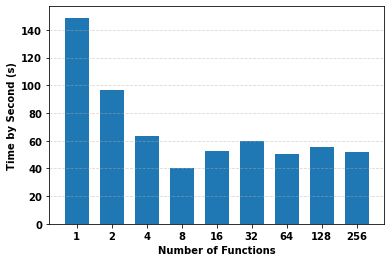

In [10]:
df2 = pd.DataFrame(processing_time)
A = list(df2['Processing_time'])

ind = np.arange(len(A))    # the x locations for the groups
width = 0.7       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, A, edgecolor='white', width=width)

plt.grid(axis='y', alpha=0.5, ls='--', zorder=0)
plt.xlabel('Number of Functions')
plt.ylabel('Time by Second (s)')
# plt.title('The processing time by using Lithops framework')
plt.xticks(ind, list(df2['Funcs_numbers']))
plt.savefig('./figures_outlier/Processing Time at time %s.png'% (datet), dpi=300, bbox_inches='tight')
plt.show()

In [11]:
df2['Proc_time'] = df2['Filtering_time'] + df2['Save_points']

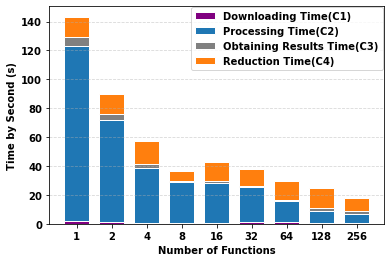

In [12]:
A = list(df2['Downloading_Time'])
B = list(df2['Proc_time'])
C = list(df2['Time_Redstart'])
D = list(df2['Reduction_time'])
# E = list(df2['Reduction_time'])

bar1 = np.add(A, B).tolist()
bar2 = np.add(A, np.add(B, C)).tolist()
# bar3 = np.add(np.add(A, B), np.add(C, D)).tolist()
ind = np.arange(len(B)) 
width = 0.7

p1 = plt.bar(ind, A, edgecolor='white', width=width, color='purple')
p2 = plt.bar(ind, B, edgecolor='white', width=width,
             bottom=A)
p3 = plt.bar(ind, C, edgecolor='white', width=width,
             bottom=bar1, color='grey')
p4 = plt.bar(ind, D, edgecolor='white', width=width,
             bottom=bar2)
# p5 = plt.bar(ind, E, edgecolor='white', width=width,
#              bottom=bar3)
plt.grid(axis='y', alpha=0.5, ls='--', zorder=0)
plt.xlabel('Number of Functions')
plt.ylabel('Time by Second (s)')
# plt.title('Approach #1: Time of Processing at a time %s'% (dt_string))
plt.xticks(ind, list(df2['Funcs_numbers']))
plt.legend((p1[0], p2[0], p3[0], p4[0]), ('Downloading Time(C1)', 'Processing Time(C2)', 'Obtaining Results Time(C3)', 
                                   'Reduction Time(C4)'), loc='upper left', bbox_to_anchor=(0.41, 1.02))
plt.savefig('./figures_outlier/Processing Time plot at time %s.png'% (datet), dpi=300, bbox_inches='tight')
plt.show()